Access the Data

In [30]:
"""
Huge credit to Ashish Jangra for collecting and curating this dataset, available at:
https://www.kaggle.com/datasets/ashishjangra27/doodle-dataset
Shoutout to Maria Saif for providing the framework for the CNN model:
https://www.kaggle.com/code/mariasaif/building-and-training-a-cnn-for-doodle-classificat
"""

import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishjangra27/doodle-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/dori/.cache/kagglehub/datasets/ashishjangra27/doodle-dataset/versions/1


In [31]:
import os
print("Files in dataset directory:", os.listdir(path))

Files in dataset directory: ['doodle', 'master_doodle_dataframe.csv']


Explore the Data

In [32]:
import pandas as pd
df = pd.read_csv(path + "/master_doodle_dataframe.csv")
print(df.head())

  countrycode                                            drawing  \
0          RO  [[[0, 5, 3, 4, 10, 72, 82, 91, 99, 98, 87, 71,...   
1          US  [[[0, 255], [3, 4]], [[86, 73, 73, 76, 85, 130...   
2          ZA  [[[39, 33, 34, 39, 52, 61, 66, 65, 67, 71], [2...   
3          VN  [[[12, 9], [128, 255]], [[0, 23, 36, 37, 42, 5...   
4          HU  [[[9, 7, 0, 19, 49, 90, 96, 99, 93, 94, 62, 16...   

             key_id  recognized           word  \
0  5613582005829632        True  traffic light   
1  5769631006457856        True  traffic light   
2  4999795544424448        True  traffic light   
3  4878417906368512        True  traffic light   
4  5572841187573760        True  traffic light   

                                image_path  
0  data/traffic light/5613582005829632.png  
1  data/traffic light/5769631006457856.png  
2  data/traffic light/4999795544424448.png  
3  data/traffic light/4878417906368512.png  
4  data/traffic light/5572841187573760.png  


In [33]:
# Check the shape of the dataframe
print("Shape of the dataframe:", df.shape)

# Display basic statistics of the dataset
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Check data types of each column
print(df.dtypes)

# Get unique values in 'word' column
unique_words = df['word'].unique()
print("Unique words (classes):", unique_words)
print("Number of unique words:", len(unique_words))




Shape of the dataframe: (1020000, 6)
             key_id
count  1.020000e+06
mean   5.630078e+15
std    6.500708e+14
min    4.503606e+15
25%    5.066571e+15
50%    5.630318e+15
75%    6.192766e+15
max    6.755396e+15
countrycode    46
drawing         0
key_id          0
recognized      0
word            0
image_path      0
dtype: int64
countrycode    object
drawing        object
key_id          int64
recognized       bool
word           object
image_path     object
dtype: object
Unique words (classes): ['traffic light' 'rhinoceros' 'bed' 'school bus' 'van' 'octopus'
 'firetruck' 'laptop' 'tractor' 'matches' 'windmill' 'square' 'pineapple'
 'candle' 'mosquito' 'pear' 'boomerang' 'lollipop' 'yoga' 'waterslide'
 'swan' 'triangle' 'diving board' 'crayon' 'hockey puck' 'moustache'
 'calendar' 'cow' 'fire hydrant' 'hot air balloon' 'helmet' 'parrot'
 'hot tub' 'baseball' 'saw' 'mouth' 'passport' 'campfire' 'car'
 'bulldozer' 'pencil' 'wine glass' 'marker' 'axe' 'mug' 'see saw' 'foot'
 'door'

Preprocess

In [ ]:
df_sample = df.sample(n=5000, random_state=42)  # Sample 5,000 drawings for initial training
# df_sample = df.sample(n=50000, random_state=42)  # Sample 50,000 drawings for initial training



In [35]:
import numpy as np
import cv2
import ast
from tqdm import tqdm  # Import tqdm

# Function to convert stroke-based drawings to images
def strokes_to_image(strokes, size=(64, 64)):
    img = np.zeros(size, dtype=np.uint8)
    for stroke in strokes:
        for i in range(len(stroke[0]) - 1):
            x1, y1 = stroke[0][i], stroke[1][i]
            x2, y2 = stroke[0][i + 1], stroke[1][i + 1]
            img = cv2.line(img, (x1, y1), (x2, y2), 255, 2)
        
    return img

# Batch processing to convert all drawings
def convert_drawings_to_images(dataframe):
    images = []
    for drawing in tqdm(dataframe['drawing'], desc='Converting drawings to images'):
        strokes = ast.literal_eval(drawing)
        img = strokes_to_image(strokes, size=(64, 64))
        images.append(img)
    return np.array(images)

# Convert drawings to images using the sampled dataframe
df_sample['drawing_image'] = convert_drawings_to_images(df_sample).tolist()


Converting drawings to images: 100%|██████████| 5000/5000 [00:01<00:00, 3154.72it/s]


In [36]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Convert images to numpy arrays and normalize
X = np.stack(df_sample['drawing_image'].values).astype('float32') / 255.0
X = X.reshape(-1, 1, 64, 64)  # PyTorch format (batch, channels, height, width)

# Encode labels using the sampled dataframe
# make each row of y a one-hot encoded vector for the corresponding label
le = LabelEncoder()
y = le.fit_transform(df_sample['word']).astype(np.int32)

# Check shapes
print(f"Shape of X: {X.shape}")  # Should be (50000, 1, 64, 64)
print(f"Shape of y: {y.shape}")  # Should be (50000,)

Shape of X: (5000, 1, 64, 64)
Shape of y: (5000,)


In [37]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (4000, 1, 64, 64), (4000,)
Testing set shape: (1000, 1, 64, 64), (1000,)


Building the CNN

In [ ]:
from torch import nn, optim
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Define the CNN model
class DoodleCNN(nn.Module):
    """
    A Convolutional Neural Network (CNN) for classifying doodle images of size 64x64 pixels.
    """
    def __init__(self, num_classes):
        super(DoodleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training Epoch"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    accuracy = correct / total
    return epoch_loss, accuracy

def validate_model(model, X_test, y_test, criterion, device, batch_size=64):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    # Process validation data in batches to avoid memory issues
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = torch.tensor(X_test[i:i+batch_size], dtype=torch.float32).to(device)
            batch_y = torch.tensor(y_test[i:i+batch_size], dtype=torch.long).to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    avg_loss = total_loss / (len(X_test) // batch_size + 1)
    accuracy = correct / total
    return avg_loss, accuracy


In [45]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_classes = y.max() + 1
model = DoodleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5) 
num_epochs = 10
batch_size = 64  # Reduced batch size to manage memory

# Convert to tensors with correct data types
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Use long for class indices

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Reduce batch size

history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

for epoch in range(num_epochs):
    # Training
    train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_accuracy = validate_model(model, X_test, y_test, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    # Clear GPU cache periodically
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Save the trained model
torch.save(model.state_dict(), "doodle_cnn.pth")
print("Model saved successfully!")

Using device: cpu


Training Epoch: 100%|██████████| 63/63 [00:22<00:00,  2.79it/s]


Epoch 1/10
  Train - Loss: 5.8248, Accuracy: 0.0032
  Val   - Loss: 5.8016, Accuracy: 0.0070


Training Epoch: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]


Epoch 2/10
  Train - Loss: 5.6621, Accuracy: 0.0143
  Val   - Loss: 5.6678, Accuracy: 0.0100


Training Epoch: 100%|██████████| 63/63 [00:23<00:00,  2.65it/s]


Epoch 3/10
  Train - Loss: 5.2544, Accuracy: 0.0307
  Val   - Loss: 5.6080, Accuracy: 0.0180


Training Epoch: 100%|██████████| 63/63 [00:13<00:00,  4.60it/s]


Epoch 4/10
  Train - Loss: 4.7425, Accuracy: 0.0658
  Val   - Loss: 5.6951, Accuracy: 0.0230


Training Epoch: 100%|██████████| 63/63 [00:14<00:00,  4.49it/s]


Epoch 5/10
  Train - Loss: 4.1603, Accuracy: 0.1158
  Val   - Loss: 5.9683, Accuracy: 0.0220


Training Epoch: 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]


Epoch 6/10
  Train - Loss: 3.5434, Accuracy: 0.2097
  Val   - Loss: 6.2335, Accuracy: 0.0220


Training Epoch: 100%|██████████| 63/63 [00:15<00:00,  3.97it/s]


Epoch 7/10
  Train - Loss: 2.9126, Accuracy: 0.3265
  Val   - Loss: 7.1726, Accuracy: 0.0250


Training Epoch: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s]


Epoch 8/10
  Train - Loss: 2.4673, Accuracy: 0.4295
  Val   - Loss: 7.6376, Accuracy: 0.0220


Training Epoch: 100%|██████████| 63/63 [00:13<00:00,  4.54it/s]


Epoch 9/10
  Train - Loss: 2.1045, Accuracy: 0.5110
  Val   - Loss: 8.1833, Accuracy: 0.0160


Training Epoch: 100%|██████████| 63/63 [00:12<00:00,  5.16it/s]


Epoch 10/10
  Train - Loss: 1.8413, Accuracy: 0.5655
  Val   - Loss: 8.8971, Accuracy: 0.0130
Model saved successfully!


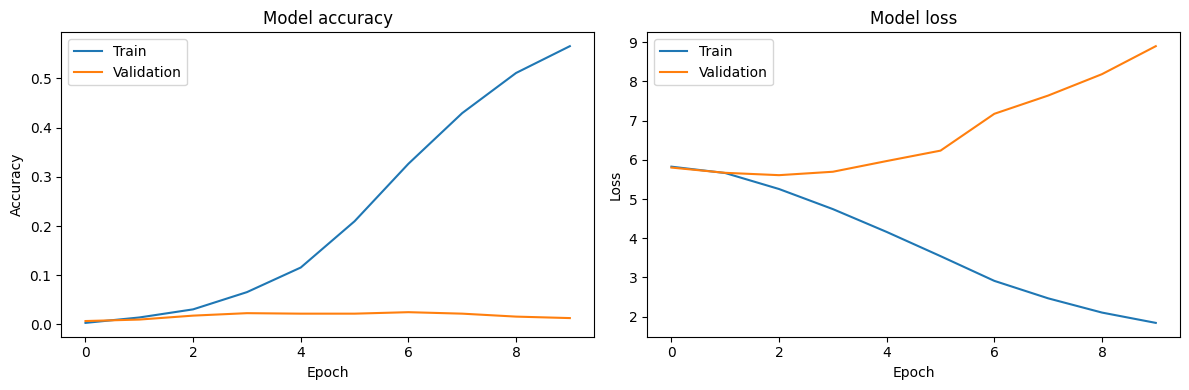

In [46]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_accuracy'])  # Remove .history
plt.plot(history['val_accuracy'])    # Remove .history
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'])      # Remove .history
plt.plot(history['val_loss'])        # Remove .history
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()